**Limpeza**: Para limpar os dados, precisamos trabalhar com:
 - os valores faltantes: dispneia, febre e tosse no nosso caso (vamos remover).
 - Valores especiais: Variáveis numericas podem ter varios valores especiais formatados, como +/- Inf, NA e NaN, ou textuais com caracteres especiais. 
 - Pontos fora da curva: Deve-se detectar, mas não necessariamente remover. A sua inclusão ou exclusão é uma decisão estatística. (Não temos esse caso no nosso conjunto de dados).
 - Iconsistências obvias: Alguém não pode ter inicio dos sintomas após a data atual. Alguém não pode estar em óbito e recuperado. (Não temos esse caso no nosso conjunto de dados).


**Engenharia**: Também chamada de Mineração, e existem algumas tecnicas como:
 - Decompozição: Converter uma data 2021-03-18T18:23:50 em outros campos categoricos como hora_do_dia, periodo_do_dia, etc (Podemos extrair de 'CONDICOES')
 - Discretização: Em alguns casos, pode-se discretizar algumas variaveis continuas que se tem, para que algoritmos performem mais rapidamente (Não aplicável aos nossos dados)
 - Mudar quantidades numericas: Mudar gramas para kg, mudar h para dias. Perdendo algum detalhe mas pode ajudar em calculos
 - Cruzamento de caracteristica: Criar novas caracteristicas (*features*) como uma combinação de características existentes. Pode ser multiplicar variaveis numericas, ou mesmo combinar variaveis categoricas. É uma boa maneira de adicionar conhecimento especializado ao conjunto de dados.
 
 
A **transformação** de dados, dentro da engenharia, refere-se aos processos que convergem em uma reestruturação dos dados a partir das fontes originais. Em outras palavras, o objetivo da transformação é, partindo de um estado complexo e ilegível dos dados originais, apresentar os dados em novos formatos e estruturas que facilitema análise e a geração de *insights*.

## 0. Carregamento das bibliotecas

In [1]:
# pacotes padrao
import os, sys, types, time, datetime, math, random, unidecode

# Para nuvem de palavras
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Manipulacao de dados
import numpy as np
import pandas as pd

# Visualizacao de dados
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

# Lidando com Warnings 
import warnings
warnings.filterwarnings('ignore')

# plotagem Inline
%matplotlib inline

## 1. Carregamento dos dados

In [2]:
df = pd.read_csv("files/20210311.csv", sep=';')

## 2. Limpeza, engenharia e transformação

#### 2.1 Remoção das colunas que não utilizaremos

Como visto na exploração dos dados, existem algumas colunas que não agregam informação com relação ao nosso objetivo (prever a chance de óbito); portanto removeremos estas colunas, e selecionaremos apenas o conjunto de dados que nos interessa.

In [3]:
df.drop(columns=['COD_IBGE', 'MUNICIPIO', 'COD_REGIAO_COVID', 'REGIAO_COVID',
                 'FONTE_INFORMACAO', 'BAIRRO', 'PAIS_NASCIMENTO', 'PES_PRIV_LIBERDADE', 
                 'PROFISSIONAL_SAUDE', 'DATA_EVOLUCAO', 'DATA_CONFIRMACAO', 'DATA_SINTOMAS', 
                 'DATA_INCLUSAO_OBITO', 'HOSPITALIZACAO_SRAG',
                 'DATA_EVOLUCAO_ESTIMADA', 'ETNIA_INDIGENA', 'OUTROS'], inplace=True)

df.columns

Index(['SEXO', 'FAIXAETARIA', 'CRITERIO', 'EVOLUCAO', 'HOSPITALIZADO', 'FEBRE',
       'TOSSE', 'GARGANTA', 'DISPNEIA', 'CONDICOES', 'GESTANTE', 'RACA_COR'],
      dtype='object')

#### 2.2 Remoção dos registros (linhas) com dados faltantes

Como `CONDICOES` é um campo extra, este estar com dados faltantes não importa. Portanto, vamos remover os registros que não possuem dados sobre as *features* já existentes

In [4]:
print((df.isnull().sum() / df.shape[0]).sort_values(ascending=False) * 100)

CONDICOES        86.104533
DISPNEIA          1.023803
GARGANTA          0.002803
TOSSE             0.002803
FEBRE             0.002803
RACA_COR          0.000000
GESTANTE          0.000000
HOSPITALIZADO     0.000000
EVOLUCAO          0.000000
CRITERIO          0.000000
FAIXAETARIA       0.000000
SEXO              0.000000
dtype: float64


In [5]:
# antes da remoção
df.shape[0]

713614

In [6]:
df.dropna(axis=0, how='any', subset=['SEXO', 'FAIXAETARIA', 'EVOLUCAO', 'FEBRE', 'TOSSE', 'GARGANTA',
       'DISPNEIA', 'GESTANTE', 'RACA_COR'], inplace=True)

In [7]:
print((df.isnull().sum() / df.shape[0]).sort_values(ascending=False) * 100)

CONDICOES        86.223574
RACA_COR          0.000000
GESTANTE          0.000000
DISPNEIA          0.000000
GARGANTA          0.000000
TOSSE             0.000000
FEBRE             0.000000
HOSPITALIZADO     0.000000
EVOLUCAO          0.000000
CRITERIO          0.000000
FAIXAETARIA       0.000000
SEXO              0.000000
dtype: float64


In [8]:
# registros após a remoção
df.shape[0]

706308

In [9]:
df['RACA_COR'].value_counts()

BRANCA           534507
NAO INFORMADO    111265
PRETA             26682
PARDA             25981
AMARELA            6240
INDIGENA           1633
Name: RACA_COR, dtype: int64

Há também 111265 casos sem raca e cor confirmados. Vamos removê-los

In [10]:
df = df[df['RACA_COR'] != 'NAO INFORMADO']

In [11]:
# registros após a remoção
df.shape[0]

595043

#### 2.3 Engenharia/transformação dos dados (feature engineering)

**Variável: ```EVOLUCAO```**

Como queremos prever os casos hospitalizados que evoluíram para óbito por COVID, primeiramente vamos extrair os casos hospitalizados (HOSPITALIZADO = 'SIM'). Após isso, precisamos dos dados que estão com EVOLUCAO = 'OBITO', e também dos não-óbito (RECUPERADO).
Para isso, vamos selecionar a fatia dos dados que possuem evolucao como 'OBITO' ou 'RECUPERADO', apenas.

In [12]:
#df = df[df['CRITERIO'] == 'RT-PCR']

In [13]:
#df.shape[0]

In [14]:
df = df[(df['EVOLUCAO'] == 'OBITO') | (df['EVOLUCAO'] == 'RECUPERADO')]

In [15]:
df.shape[0]

565848

Após selecionar os dados com a evolução que precisamos, vamos mudar o nome da variavel e transformar óbito para 1 e recuperado para 0.

In [16]:
#df.rename(columns={'EVOLUCAO': 'OBITO'}, inplace=True)
df['EVOLUCAO'] = df['EVOLUCAO'].map({'OBITO': 1, 'RECUPERADO': 0})

**Variável: ```CONDICOES```**

Visualização de uma nuvem de palavras

Vamos extrair os dados da coluna `CONDICOES`, primeiramente visualizando uma nuvem de palavras para entendermos as condições ali presentes.

Para isso, precisamos de 3 passos:
 - 1) Remoção dos valores faltantes: O primeiro comando que deve ser executado é a remoção das linhas onde apresentam dados ausentes na coluna 'CONDICOES', já que nesta variável encontra-se os textos utilizados para realizar o *wordcloud*.
 - 2) Transformar em caixa baixa e remover acentos
 - 3) Junção das strings: Após a remoção das linhas, precisamos unir todas as palavras em uma única *string*. 
 - 4) Eliminar *stopwords*: Para criação de nuvem de palavras, algumas preposições ou palavras devem ser removidas (*e.g.*, do, da, dos, das, no). 

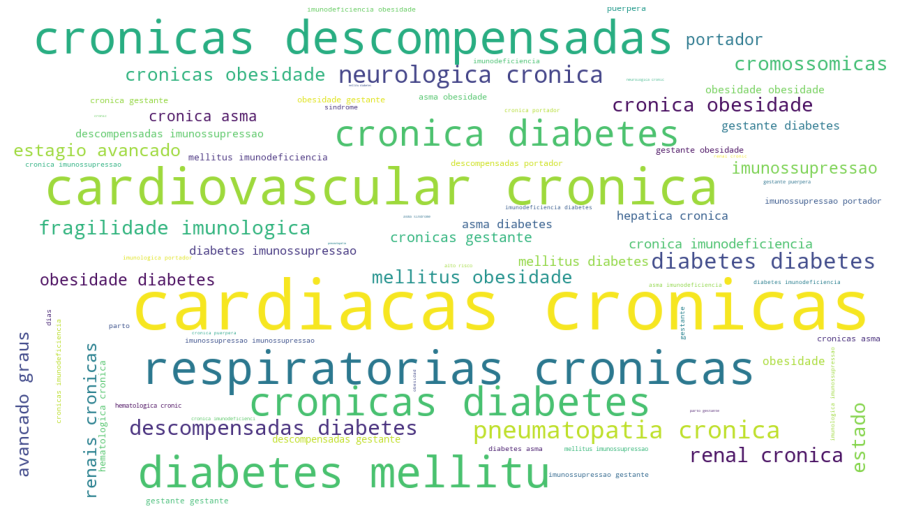

In [17]:
df_word = df.dropna(subset=['CONDICOES'], axis=0) # remocao das linhas que nao possuem condicoes extra

for col in df_word.drop('EVOLUCAO', axis=1).columns:
    df_word[col] = df_word[col].apply(unidecode.unidecode) # removendo acentos
    
df_word['CONDICOES'] = df_word['CONDICOES'].apply(str.lower) # deixando caixa baixa

conditions = df_word['CONDICOES'] # pegar apenas as condicoes
all_words_conditions = " ".join(s for s in conditions) # unir tudo em uma string

stopwords = set(STOPWORDS)
stopwords.update(["da", "meu", "em", "de", "ao", "os", "ou", 
                  'outros', 'outro', 'outra', 'ate', 'doenca', 'doencas']) # acréscimo de mais stopwords

wordcloud = WordCloud(stopwords=stopwords,
                      background_color='white', width=1280,                            
                      height=720).generate(all_words_conditions)

fig, ax = plt.subplots(figsize=(16,10))            
ax.imshow(wordcloud, interpolation='bilinear')       
ax.set_axis_off()

plt.imshow(wordcloud)                 
wordcloud.to_file('condicoes.png',);


In [18]:
import collections
import re

wordcount = collections.defaultdict(int)
pattern = r"\W"
for word in all_words_conditions.split():
    #word = re.sub(pattern, '', word)
    if word not in stopwords:
        wordcount[word] += 1

mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:50]

In [19]:
for word, count in mc:
    print(word, ":", count)

cronicas : 37001
cardiacas : 29784
diabetes : 20950
cronica, : 14659
cardiovascular : 14201
respiratorias : 11327
descompensadas : 9342
cronica : 6758
mellitus, : 5902
obesidade : 5650
cronicas, : 5369
mellitus : 4037
diabetes, : 3609
gestante : 2674
imunossupressao : 2425
pneumatopatia : 2424
neurologica : 2302
descompensadas, : 1985
obesidade, : 1868
renal : 1709
portador : 1603
cromossomicas : 1603
estado : 1603
fragilidade : 1603
imunologica : 1509
renais : 1260
estagio : 1260
avancado : 1260
(graus : 1260
3, : 1260
4 : 1260
asma, : 1186
imunodeficiencia, : 1042
5) : 954
asma : 680
hepatica : 524
imunodeficiencia : 437
imunossupressao, : 391
hematologica : 370
5), : 306
gestante, : 196
puerpera : 180
(ate : 144
45 : 144
dias : 144
parto) : 137
sindrome : 114
cronic : 113
imunologica, : 94
down, : 76


In [20]:
word_freq = WordCloud().process_text(all_words_conditions)
dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))

{'doencas cardiacas': 29784,
 'cardiacas cronicas': 29784,
 'cronicas doenca': 16821,
 'doenca cardiovascular': 14201,
 'cardiovascular cronica': 14201,
 'doencas respiratorias': 11327,
 'respiratorias cronicas': 11327,
 'cronicas descompensadas': 11327,
 'diabetes doenca': 10032,
 'diabetes mellitu': 9971,
 'cronicas diabetes': 8128,
 'descompensadas doenca': 7610,
 'outros doenca': 7300,
 'cronica diabetes': 6548,
 'cronica doenca': 5890,
 'cronica outro': 4345,
 'mellitus doenca': 3725,
 'obesidade doenca': 3548,
 'mellitus outro': 2826,
 'outra pneumatopatia': 2424,
 'pneumatopatia cronica': 2416,
 'doenca neurologica': 2302,
 'neurologica cronica': 2290,
 'outros diabetes': 2256,
 'obesidade outro': 1840,
 'descompensadas diabetes': 1824,
 'imunossupressao doenca': 1726,
 'doenca renal': 1709,
 'renal cronica': 1689,
 'portador de': 1603,
 'de doencas': 1603,
 'doencas cromossomicas': 1603,
 'cromossomicas ou': 1603,
 'ou estado': 1603,
 'estado de': 1603,
 'de fragilidade': 1603,

Com a análise do campo textual, podemos visualizar algumas condições das quais podemos extrair. Devemos nos atentar para sinônimos, como 'doença cardíada' e 'doença cardiovascular', 'mellitus' ou 'diabetes. Outro ponto importante a se notar, são erros de digitação, como 'mellitu' ou 'asm', ou 'pneumopatia' como 'pneumatopatia'

As doenças/condições que extrairemos a partir do campo `CONDICOES` são:

- `CARDIOPATIA` = Doença cardiovascular ou doença cardíaca
- `DIABETES` = Diabetes ou Mellitus
- `DOENCA_RESPIRATORIA` = Asma, pneumopatia ou doença pulmonar
- `DOENCA_NEUROLOGICA` = Doenças neurológicas crônicas
- `PROBLEMA_RENAL` = Problemas renais
- `OBESIDADE` = Obeso
- `IMUNODEFICIENCIA` = Imunodeficiencia
- `IMUNOSSUPRESSAO` =  imunossupressao
- `GESTANTE` = Gestante
- `HEPATITE` = Doenças hepáticas
- `DOENCA_CROMOSSOMICA` = Sindrome de down
- `HEMATOLOGICA` = Doenças hematológicas
- `Puerpera` = Puerpera ou puerpério

Antes de extraírmos, vamos deixar os dados em caixa baixa, para facilitar a extração do conhecimento.

In [21]:
df['CONDICOES'] = df['CONDICOES'].apply(lambda x: str.lower(x) if not isinstance(x, float) else np.nan) # deixando caixa baixa

df['CARDIOPATIA'] = ['SIM' if any(string in str(row) for string in ['cardiovascular', 'cardiacas']) else 
                        'NAO' for row in df['CONDICOES']]

df['DIABETES'] = ['SIM' if any(string in str(row) for string in ['diabetes', 'mellitus', 'mellitu']) else 
                  'NAO' for row in df['CONDICOES']]

df['DOENCA_RESPIRATORIA'] = ['SIM' if any(string in str(row) for string in ['respiratorias', 'asma', 'asm', 'pneumopatia', 'pneumatopatia']) else 
                         'NAO' for row in df['CONDICOES']]

df['DOENCA_NEUROLOGICA'] = ['SIM' if any(string in str(row) for string in ['neurologica']) else 
                      'NÃO' for row in df['CONDICOES']]

df['PROBLEMA_RENAL'] = ['SIM' if any(string in str(row) for string in ['renais', 'renal']) else 
                      'NÃO' for row in df['CONDICOES']]

df['OBESIDADE'] = ['SIM' if any(string in str(row) for string in ['obesidade', 'obesidad']) else 
                   'NAO' for row in df['CONDICOES']]

df['IMUNODEFICIENCIA'] = ['SIM' if any(string in str(row) for string in ['imunodeficiencia']) else 
                         'NAO' for row in df['CONDICOES']]

df['IMUNOSSUPRESSAO'] = ['SIM' if any(string in str(row) for string in ['imunossupressao']) else 
                         'NAO' for row in df['CONDICOES']]

df['GESTANTE'] = ['SIM' if any(string in str(row) for string in ['gestante']) else 
                  gestante for row, gestante in zip(df['CONDICOES'], df['GESTANTE'])]

df['HEPATITE'] = ['SIM' if any(string in str(row) for string in ['hepatica', 'hepatite']) else 
                  'NAO' for row in df['CONDICOES']]

df['DOENCA_CROMOSSOMICA'] = ['SIM' if any(string in str(row) for string in ['cromossomicas', 'down']) else 
                  'NAO' for row in df['CONDICOES']]

df['DOENCA_HEMATOLOGICA'] = ['SIM' if any(string in str(row) for string in ['hematologica']) else 
                  'NAO' for row in df['CONDICOES']]

df['PUERPERA'] = ['SIM' if any(string in str(row) for string in ['puerpera']) else 
                  'NAO' for row in df['CONDICOES']]

In [22]:
df.drop(columns=['CONDICOES', 'HOSPITALIZADO', 'CRITERIO'], inplace=True) # nao precisamos mais das condicoes, nem do hospitalizado
df.columns

Index(['SEXO', 'FAIXAETARIA', 'EVOLUCAO', 'FEBRE', 'TOSSE', 'GARGANTA',
       'DISPNEIA', 'GESTANTE', 'RACA_COR', 'CARDIOPATIA', 'DIABETES',
       'DOENCA_RESPIRATORIA', 'DOENCA_NEUROLOGICA', 'PROBLEMA_RENAL',
       'OBESIDADE', 'IMUNODEFICIENCIA', 'IMUNOSSUPRESSAO', 'HEPATITE',
       'DOENCA_CROMOSSOMICA', 'DOENCA_HEMATOLOGICA', 'PUERPERA'],
      dtype='object')

## [EXTRA] 4. Perfil de óbitos por covid no estado do Rio Grande do Sul

Vamos analisar os sintomas/condicoes mais presentes nos pacientes que vieram a obito por covid.

In [23]:
df_obitos = df[df['EVOLUCAO'] == 1]

In [24]:
df_obitos

,SEXO,FAIXAETARIA,EVOLUCAO,FEBRE,TOSSE,GARGANTA,DISPNEIA,GESTANTE,RACA_COR,CARDIOPATIA,...,DOENCA_RESPIRATORIA,DOENCA_NEUROLOGICA,PROBLEMA_RENAL,OBESIDADE,IMUNODEFICIENCIA,IMUNOSSUPRESSAO,HEPATITE,DOENCA_CROMOSSOMICA,DOENCA_HEMATOLOGICA,PUERPERA
161,Feminino,80 e mais,1,NAO,SIM,NAO,SIM,NAO,BRANCA,SIM,...,NAO,NÃO,NÃO,NAO,NAO,NAO,NAO,NAO,NAO,NAO
166,Feminino,80 e mais,1,NAO,NAO,NAO,SIM,NAO,BRANCA,NAO,...,NAO,NÃO,NÃO,NAO,NAO,NAO,NAO,NAO,NAO,NAO
284,Masculino,80 e mais,1,SIM,SIM,NAO,SIM,NAO,BRANCA,SIM,...,NAO,NÃO,NÃO,NAO,NAO,NAO,NAO,NAO,NAO,NAO
354,Feminino,50 a 59,1,SIM,SIM,SIM,SIM,NAO,BRANCA,SIM,...,NAO,NÃO,NÃO,SIM,NAO,NAO,NAO,NAO,NAO,NAO
363,Masculino,70 a 79,1,SIM,SIM,NAO,SIM,NAO,BRANCA,SIM,...,NAO,NÃO,NÃO,NAO,NAO,NAO,NAO,NAO,NAO,NAO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713414,Masculino,70 a 79,1,SIM,SIM,SIM,SIM,NAO,BRANCA,NAO,...,NAO,NÃO,NÃO,NAO,NAO,NAO,NAO,NAO,NAO,NAO
713461,Feminino,50 a 59,1,NAO,SIM,SIM,NAO,NAO,BRANCA,SIM,...,NAO,NÃO,NÃO,NAO,NAO,NAO,NAO,NAO,NAO,NAO
713492,Feminino,70 a 79,1,NAO,NAO,NAO,SIM,NAO,BRANCA,SIM,...,NAO,NÃO,NÃO,NAO,NAO,NAO,NAO,NAO,NAO,NAO
713573,Masculino,60 a 69,1,NAO,SIM,NAO,SIM,NAO,BRANCA,NAO,...,NAO,NÃO,NÃO,NAO,NAO,NAO,NAO,NAO,NAO,NAO


In [25]:
df_recuperados = df[df['EVOLUCAO'] == 0]
for row in df_recuperados: # só para percorrer, nao importa o df
    print('------------------------------')
    print(row)
    total_rec = df_recuperados[row].value_counts(dropna=False, sort=False)
    total_obitos = df_obitos[row].value_counts(dropna=False, sort=False)
    total = total_rec + total_obitos
    porcentagem = df[row].value_counts(dropna=False, normalize=True) * 100
    porcentagem_obitos = (total_obitos/total) * 100
    porcentagem_recuperados = (total_rec/total) * 100
    
    print(pd.concat([total, porcentagem, total_rec, porcentagem_recuperados, total_obitos, porcentagem_obitos], 
                    axis=1, keys=['Total', 'Tot %', 'Total Rec', 'Rec %', 'Total Obt', 'Obt %']))
    print('------------------------------')
    

------------------------------
SEXO
            Total      Tot %  Total Rec      Rec %  Total Obt     Obt %
Feminino   307298  54.307517     303050  98.617628       4248  1.382372
Masculino  258550  45.692483     253286  97.964030       5264  2.035970
------------------------------
------------------------------
FAIXAETARIA
            Total      Tot %  Total Rec      Rec %  Total Obt      Obt %
01 a 04      7303   1.290629       7299  99.945228          4   0.054772
05 a 09      8581   1.516485       8579  99.976693          2   0.023307
10 a 14     10642   1.880717      10640  99.981207          2   0.018793
15 a 19     23934   4.229758      23920  99.941506         14   0.058494
20 a 29    109275  19.311723     109203  99.934111         72   0.065889
30 a 39    125074  22.103816     124864  99.832099        210   0.167901
40 a 49    101034  17.855325     100534  99.505117        500   0.494883
50 a 59     83274  14.716673      82235  98.752312       1039   1.247688
60 a 69     54050

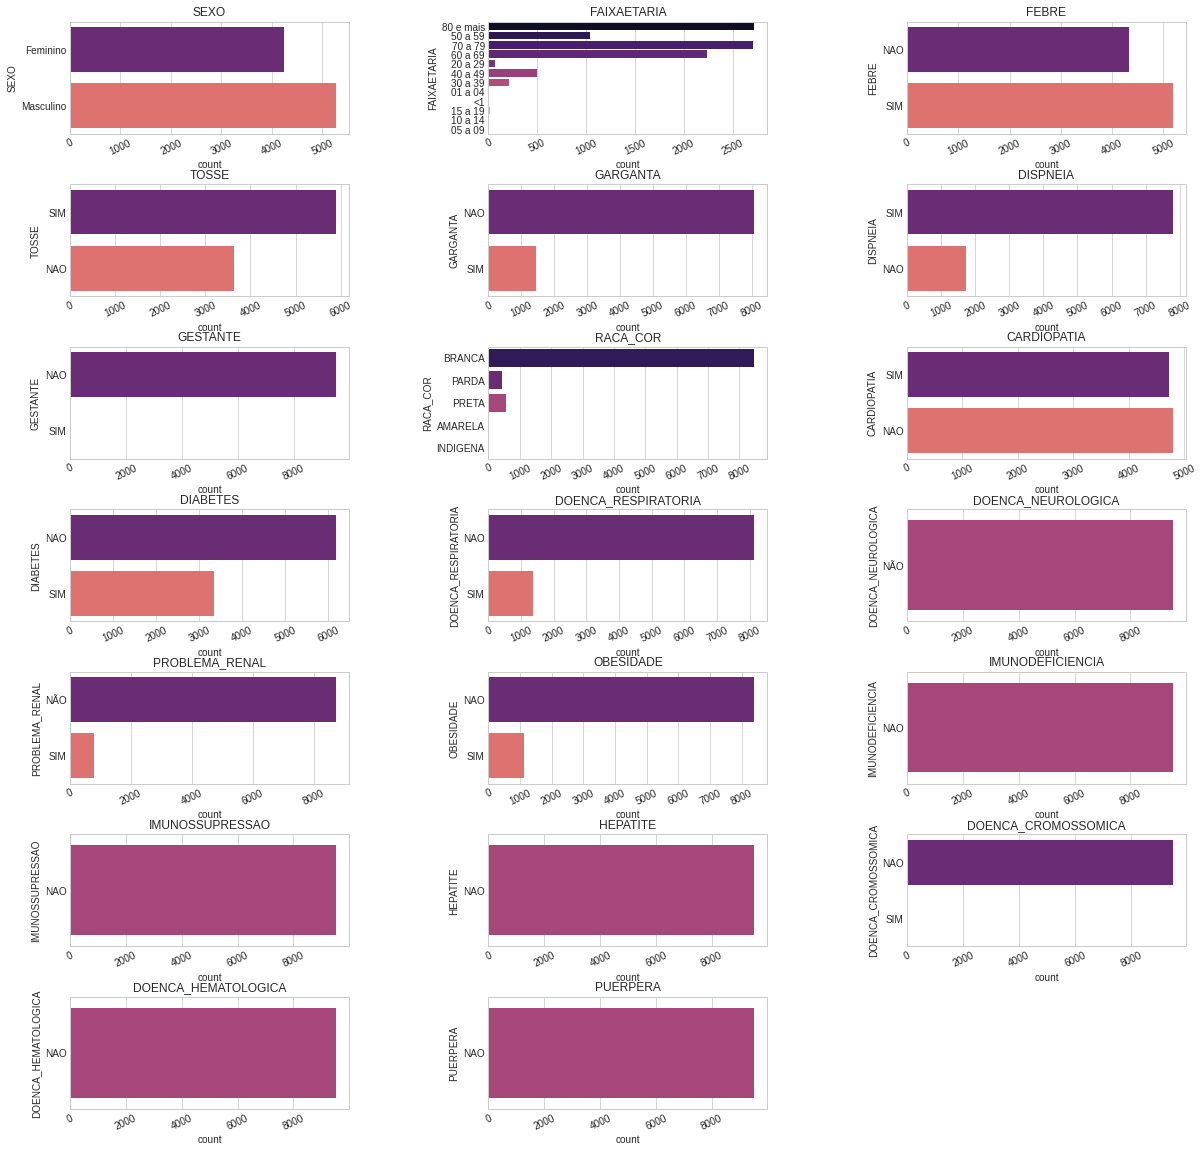

In [26]:
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset, palette="magma")
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)
    
plot_distribution(df_obitos.drop(['EVOLUCAO'], axis=1), cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

Análise inciial do perfil do paciente que vem a óbito é:

Paciente com:

- `Sexo` = Masculino
- `Faixa etária` = 80 anos ou mais
- `Cor` = Branca
- `Febre` = Sim
- `Tosse` = Sim
- `Dispneia` = Sim
- `Cardiopatia` = Não
- `Dor de garganta` = Não
- `Diabetes` = Não (embora tenha numero alto de óbitos aqui)
- `Gestante` = Não 
- `Doença respiratória` = Não
- `Doença neurologica` = Não
- `Problema renal` = 'Não'
- `Obesidade` = Não
- `Imunodeficiencia` = Não
- `Imunossupressão` = Não
- `Hepatite` = Não
- `Doença cromossomica` = Não
- `Puerpera` = Não


Ainda não tem a proporção de Valores relacionados a evolução para recuperado ou óbito, o que faz com que esse primeiro perfil não seja bastante confiável. Exemplo: Hepatite como maior valor sendo Não, porém uma pequena parcela apresenta hepatite. Portanto, não podemos concluir que ter hepatite significa que não vem a óbito, sem antes verificar a variavel isoladamente, da proporção da doença na coorte total.




## 3. Conclusão

Após a limpeza e mineração de dados, vamos armazena-los a fim de que possam ser utilizados para treinar modelos preditivos.

In [27]:
df.to_csv("covid_11_marco_limpo.csv", sep=';', index=False)

###### 